In [1]:
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd

ModuleNotFoundError: No module named 'cantera'

In [ ]:
def brayton(T1gt, P1gt, rp, T3gt, P4gt, Tex):
    air = ct.Solution('air.yaml')

    #1 Compressor Inlet
    T1gt = T1gt
    P1gt = P1gt
    air.TP = T1gt, P1gt
    s1gt = air.entropy_mass
    h1gt = air.enthalpy_mass

    #2 Compressor outlet
    P2gt = P1gt * rp
    air.SP = s1gt, P2gt #isentropic compression
    h2gt = ((air.enthalpy_mass - h1gt)/0.80) + h1gt
    air.HP = h2gt, P2gt
    T2gt = air.T

    #3 Turbine inlet
    T3gt = T3gt
    P3gt = P2gt
    air.TP = T3gt, P3gt
    s3gt = air.entropy_mass
    h3gt = air.enthalpy_mass

    #4 Turbine outlet
    P4gt = P4gt
    air.SP = s3gt, P4gt
    h4gt = h3gt - ((h3gt - air.enthalpy_mass) * 0.75) #isentropic expansion
    air.HP = h4gt, P4gt
    T4gt = air.T

    #5 Heat Exchanger Outlet
    P5gt = P4gt
    T5gt = Tex
    air.TP = T5gt, P5gt

    return T1gt, P1gt, T2gt, P2gt, T3gt, P3gt, T4gt, P4gt, T5gt, P5gt


In [ ]:
def rankine(P1st, P2st, T4gt, P4gt, Pex, Tex):
    water = ct.Solution('water.yaml')

    #1 Pump inlet
    P1st = P1st

    water_dummy = ct.Water()
    water_dummy.TP = 500, P1st # Dummy value for T1st, just to get the saturation temperature
    T1st = water_dummy.T_sat # Saturation Temperature

    Q1st = 0
    water.TPX = T1st, P1st, Q1st
    T1st = water.T
    h1st = water.enthalpy_mass
    s1st = water.entropy_mass

    #2 Pump outlet
    P2st = P2st
    water.SP = s1st, P2st
    h2st = h1st + ((water.enthalpy_mass - h1st) / 0.90)
    water.HP = h2st, P2st
    T2st = water.T

    #3 HRSG Outlet
    P3st = P2st

    exhaust = ct.Solution('air.yaml')
    exhaust.TP = T4gt, Pex
    inlet_h = exhaust.enthalpy_mass
    exhaust.TP = Tex, Pex
    outlet_h = exhaust.enthalpy_mass

    theoretical_max = ct.Solution('water.yaml')
    theoretical_max.TP = T4gt, P2st # Theoretical Max outlet temp is the same as the turbine inlet
    h3st_max = theoretical_max.enthalpy_mass # Theoretical Max

    h3st = h2st + (0.82 *(h3st_max - h2st)) # Actual enthalpy of steam

    mr = (h3st_max - h2st) / (inlet_h - outlet_h) # Mass Ratio of Steam to Air

    water.HP = h3st, P3st
    T3st = water.T
    s3st = water.entropy_mass

    #3 Turbine Outlet
    P4st = P1st
    water.SP = s3st, P4st
    h4st = h3st - 0.85 * (h3st - water.enthalpy_mass)
    water.HP = h4st, P4st
    T4st = water.T

    return T1st, P1st, T2st, P2st, T3st, P3st, T4st, P4st, mr


In [ ]:
def combined(T1gt, P1gt, rp, T3gt, P4gt, Tex, P1st, P2st):
    T1gt, P1gt, T2gt, P2gt, T3gt, P3gt, T4gt, P4gt, T5gt, P5gt = brayton(T1gt, P1gt, rp, T3gt, P4gt, Tex)
    T1st, P1st, T2st, P2st, T3st, P3st, T4st, P4st, mr = rankine(P1st, P2st, T4gt, P4gt, P5gt, T5gt)
    return T1gt, P1gt, T2gt, P2gt, T3gt, P3gt, T4gt, P4gt, T5gt, P5gt, T1st, P1st, T2st, P2st, T3st, P3st, T4st, P4st, mr, rp

In [ ]:
# Work, Heat, Enthalpy Change, and Exergy Change for each component
def component_analysis(Ti, Pi, Te, Pe, Component, Fluid, To):
    if Component == "Producer":
        if Fluid == "Air":
            inlet_state = ct.Solution('air.yaml')
            inlet_state.TP = Ti, Pi
            outlet_state = ct.Solution('air.yaml')
            outlet_state.TP = Te, Pe
            ideal_outlet_state = ct.Solution('air.yaml')
            ideal_outlet_state.SP = inlet_state.s, Pe
        elif Fluid == "Water":
            inlet_state = ct.Solution('water.yaml')
            inlet_state.TP = Ti, Pi
            outlet_state = ct.Solution('water.yaml')
            outlet_state.TP = Te, Pe
            ideal_outlet_state = ct.Solution('water.yaml')
            ideal_outlet_state.SP = inlet_state.s, Pe
        # Work
        work = abs(outlet_state.h - inlet_state.h)
        rev_work = abs(outlet_state.h - inlet_state.h + To*(outlet_state.s - inlet_state.s))
        # Heat
        heat = 0
        # Enthalpy Change
        enthalpy_change = outlet_state.h - inlet_state.h
        # Exergy Change
        exergy_change = outlet_state.h - inlet_state.h - To*(outlet_state.s - inlet_state.s)
        #Irreversibility
        irreversibility = To*(outlet_state.s - inlet_state.s - heat/outlet_state.T)
        # Second Law Efficiency
        second_law_efficiency = work/rev_work
        return work, heat, enthalpy_change, exergy_change, irreversibility, second_law_efficiency

    elif Component == "Consumer":
        if Fluid == "Air":
            inlet_state = ct.Solution('air.yaml')
            inlet_state.TP = Ti, Pi
            outlet_state = ct.Solution('air.yaml')
            outlet_state.TP = Te, Pe
            ideal_outlet_state = ct.Solution('air.yaml')
            ideal_outlet_state.SP = inlet_state.s, Pe
        elif Fluid == "Water":
            inlet_state = ct.Solution('water.yaml')
            inlet_state.TP = Ti, Pi
            outlet_state = ct.Solution('water.yaml')
            outlet_state.TP = Te, Pe
            ideal_outlet_state = ct.Solution('water.yaml')
            ideal_outlet_state.SP = inlet_state.s, Pe
        # Work
        work = abs(outlet_state.h - inlet_state.h)
        rev_work = abs(outlet_state.h - inlet_state.h - To*(outlet_state.s - inlet_state.s))
        # Heat
        heat = 0
        # Enthalpy Change
        enthalpy_change = outlet_state.h - inlet_state.h
        # Exergy Change
        exergy_change = outlet_state.h - inlet_state.h - To*(outlet_state.s - inlet_state.s)
        # Irreversibility
        irreversibility = To*(outlet_state.s - inlet_state.s - heat/outlet_state.T)
        # Second Law Efficiency
        second_law_efficiency = rev_work/work
        return work, heat, enthalpy_change, exergy_change, irreversibility, second_law_efficiency

    elif Component == "Exchanger":
        if Fluid == "Air":
            inlet_state = ct.Solution('air.yaml')
            inlet_state.TP = Ti, Pi
            outlet_state = ct.Solution('air.yaml')
            outlet_state.TP = Te, Pe
            ideal_outlet_state = ct.Solution('air.yaml')
            ideal_outlet_state.SP = inlet_state.s, Pe
        elif Fluid == "Water":
            inlet_state = ct.Solution('water.yaml')
            inlet_state.TP = Ti, Pi
            outlet_state = ct.Solution('water.yaml')
            outlet_state.TP = Te, Pe
            ideal_outlet_state = ct.Solution('water.yaml')
            ideal_outlet_state.SP = inlet_state.s, Pe
        # Work
        work = 0
        # Heat
        heat = outlet_state.h - inlet_state.h
        # Enthalpy Change
        enthalpy_change = outlet_state.h - inlet_state.h
        # Exergy Change
        exergy_change = outlet_state.h - inlet_state.h - To*(outlet_state.s - inlet_state.s)
        # Irreversibility
        average_temperature = (inlet_state.T + outlet_state.T)/2
        irreversibility = To*(outlet_state.s - inlet_state.s - heat/average_temperature)
        return work, heat, enthalpy_change, exergy_change, irreversibility

    else:
        print("Error: Component not defined")
        return 0, 0, 0, 0, 0

In [ ]:
rp_range = np.linspace(2, 20, 100)

brayton_cycle_compressor = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility", "Second Law Efficiency"])
brayton_cycle_hx = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility"])
brayton_cycle_turbine = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility", "Second Law Efficiency"])
brayton_cycle_hx2 = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility"])

rankine_cycle_pump = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility", "Second Law Efficiency"])
rankine_cycle_boiler = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility"])
rankine_cycle_turbine = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility", "Second Law Efficiency"])
rankine_cycle_condenser = pd.DataFrame(columns=["Pressure Ratio", "Component", "Work", "Heat", "Enthalpy Change", "Exergy Change", "Irreversibility"])

efficiency = pd.DataFrame(columns=["Pressure Ratio", "Mass Ratio", "Thermal Efficinency", "Net Work", "Net Work per Unit Mass", "Heat Into System"])
mr_list = []

for rp in rp_range:
    T1gt, P1gt, T2gt, P2gt, T3gt, P3gt, T4gt, P4gt, T5gt, P5gt, T1st, P1st, T2st, P2st, T3st, P3st, T4st, P4st, mr, rp = combined(300, 101325, rp, 1450, 101325, 450, 5E3, 7E5)

    compressor_brayton = component_analysis(T1gt, P1gt, T2gt, P2gt, "Consumer", "Air", 300)
    hx_brayton = component_analysis(T2gt, P2gt, T3gt, P3gt, "Exchanger", "Air", 300)
    turbine_brayton = component_analysis(T3gt, P3gt, T4gt, P4gt, "Producer", "Air", 300)
    hx2_brayton = component_analysis(T4gt, P4gt, T5gt, P5gt, "Exchanger", "Air", 300)

    pump_rankine = component_analysis(T1st, P1st, T2st, P2st, "Consumer", "Water", 300)
    boiler_rankine = component_analysis(T2st, P2st, T3st, P3st, "Exchanger", "Water", 300)
    turbine_rankine = component_analysis(T3st, P3st, T4st, P4st, "Producer", "Water", 300)
    condenser_rankine = component_analysis(T4st, P4st, T1st, P1st, "Exchanger", "Water", 300)

    #Thermal Efficiency
    #work_tot = - compressor_brayton[0] + (turbine_brayton[0] + (mr*turbine_rankine[0]))
    work_net = - compressor_brayton[0] - ((mr)*pump_rankine[0]) + turbine_brayton[0] + ((mr)*turbine_rankine[0])
    q_in = hx_brayton[1]
    thermal_eff = work_net / q_in
    work_net_unit_mass = work_net / mr
    mr_list.append(mr)


    # Make a dataframe for the Brayton Cycle
    brayton_cycle_compressor.loc[len(brayton_cycle_compressor)] = [rp, "Compressor", compressor_brayton[0], compressor_brayton[1], compressor_brayton[2], compressor_brayton[3], compressor_brayton[4], compressor_brayton[5]]
    brayton_cycle_hx.loc[len(brayton_cycle_hx)] = [rp, "Heat Exchanger", hx_brayton[0], hx_brayton[1], hx_brayton[2], hx_brayton[3], hx_brayton[4]]
    brayton_cycle_turbine.loc[len(brayton_cycle_turbine)] = [rp, "Turbine", turbine_brayton[0], turbine_brayton[1], turbine_brayton[2], turbine_brayton[3], turbine_brayton[4], turbine_brayton[5]]
    brayton_cycle_hx2.loc[len(brayton_cycle_hx2)] = [rp, "Heat Exchanger", hx2_brayton[0], hx2_brayton[1], hx2_brayton[2], hx2_brayton[3], hx2_brayton[4]]

    # Make a dataframe for the Rankine Cycle
    rankine_cycle_pump.loc[len(rankine_cycle_pump)] = [rp, "Pump", pump_rankine[0], pump_rankine[1], pump_rankine[2], pump_rankine[3], pump_rankine[4], pump_rankine[5]]
    rankine_cycle_boiler.loc[len(rankine_cycle_boiler)] = [rp, "Boiler", boiler_rankine[0], boiler_rankine[1], boiler_rankine[2], boiler_rankine[3], boiler_rankine[4]]
    rankine_cycle_turbine.loc[len(rankine_cycle_turbine)] = [rp, "Turbine", turbine_rankine[0], turbine_rankine[1], turbine_rankine[2], turbine_rankine[3], turbine_rankine[4], turbine_rankine[5]]
    rankine_cycle_condenser.loc[len(rankine_cycle_condenser)] = [rp, "Condenser", condenser_rankine[0], condenser_rankine[1], condenser_rankine[2], condenser_rankine[3], condenser_rankine[4]]

    # Make a dataframe for the Thermal Efficiency, Net Work, and Pressure Ratio
    efficiency.loc[len(efficiency)] = [rp, mr, thermal_eff, work_net, work_net_unit_mass, q_in]

In [ ]:
rankine_cycle_pump

,Pressure Ratio,Component,Work,Heat,Enthalpy Change,Exergy Change,Irreversibility,Second Law Efficiency
0,2.000000,Pump,842.118018,0,842.118018,759.580354,82.537664,0.901988
1,2.181818,Pump,842.118018,0,842.118018,759.580354,82.537664,0.901988
2,2.363636,Pump,842.118018,0,842.118018,759.580354,82.537664,0.901988
3,2.545455,Pump,842.118018,0,842.118018,759.580354,82.537664,0.901988
4,2.727273,Pump,842.118018,0,842.118018,759.580354,82.537664,0.901988
...,...,...,...,...,...,...,...,...
95,19.272727,Pump,842.118018,0,842.118018,759.580354,82.537664,0.901988
96,19.454545,Pump,842.118018,0,842.118018,759.580354,82.537664,0.901988
97,19.636364,Pump,842.118018,0,842.118018,759.580354,82.537664,0.901988
98,19.818182,Pump,842.118018,0,842.118018,759.580354,82.537664,0.901988


In [ ]:
T1gt, P1gt, T2gt, P2gt, T3gt, P3gt, T4gt, P4gt, T5gt, P5gt, T1st, P1st, T2st, P2st, T3st, P3st, T4st, P4st, mr, rp = combined(300, 101325, 20, 1450, 101325, 450, 5E3, 7E5)
print(T4gt)

882.9823428373894


In [ ]:
(brayton_cycle_turbine['Work'] - brayton_cycle_compressor['Work'])/brayton_cycle_compressor['Work']

0     1.415918
1     1.360890
2     1.311327
3     1.266328
4     1.225189
        ...   
95    0.318428
96    0.315105
97    0.311822
98    0.308576
99    0.305369
Name: Work, Length: 100, dtype: float64

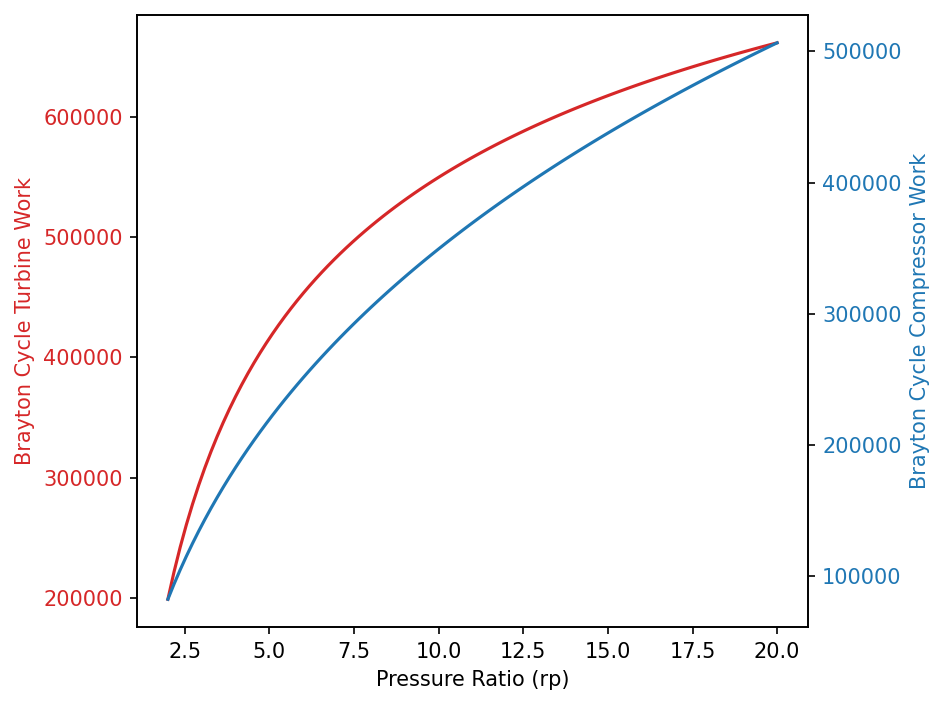

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Pressure Ratio (rp)')
ax1.set_ylabel('Brayton Cycle Turbine Work', color=color)
ax1.plot(efficiency["Pressure Ratio"], brayton_cycle_turbine['Work'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Brayton Cycle Compressor Work', color=color)
ax2.plot(efficiency["Pressure Ratio"], brayton_cycle_compressor['Work'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.figsize = (8,4)
fig.dpi = 150
fig.tight_layout()
plt.title('')
plt.show()

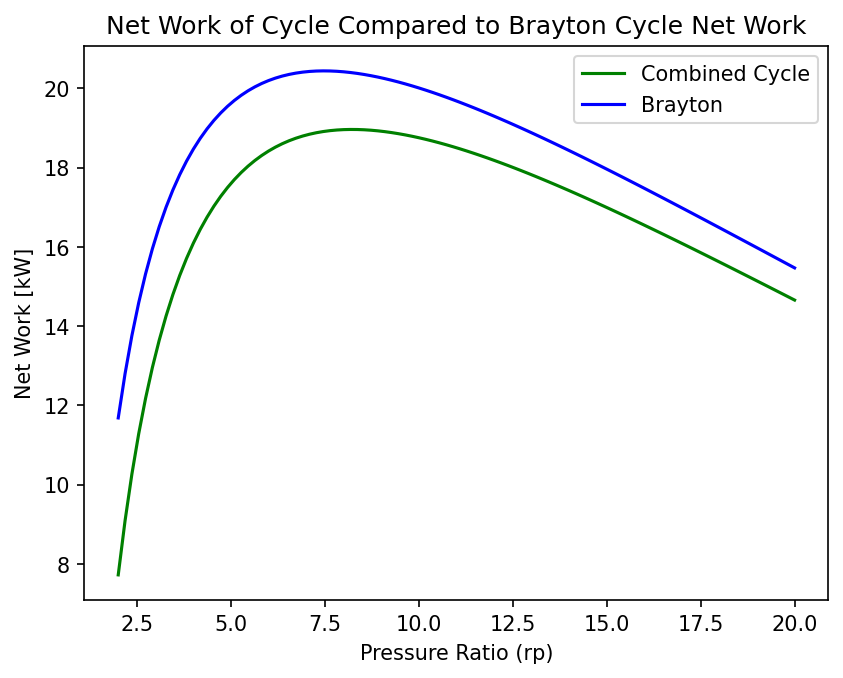

In [ ]:
plt.figure(dpi = 150)
plt.title('Net Work of Cycle Compared to Brayton Cycle Net Work')
plt.ylabel('Net Work [kW]')
plt.xlabel('Pressure Ratio (rp)')
plt.plot(efficiency["Pressure Ratio"], efficiency["Net Work"]/10e3, color = 'g', label = 'Combined Cycle')
plt.plot(efficiency["Pressure Ratio"], (brayton_cycle_turbine['Work']- brayton_cycle_compressor['Work'])/10e3, color='b', label = 'Brayton')
#plt.plot(efficiency["Pressure Ratio"],)

plt.legend()


In [ ]:
efficiency

,Pressure Ratio,Mass Ratio,Thermal Efficinency,Net Work,Net Work per Unit Mass,Heat Into System
0,2.000000,200.177605,0.064742,77189.354039,385.604344,1.192264e+06
1,2.181818,187.508818,0.076970,90879.690141,484.668886,1.180711e+06
2,2.363636,176.607966,0.087745,102646.652213,581.211906,1.169828e+06
3,2.545455,167.118504,0.097319,112843.948054,675.233116,1.159530e+06
4,2.727273,158.774934,0.105886,121741.729889,766.756607,1.149746e+06
...,...,...,...,...,...,...
95,19.272727,41.963749,0.193054,150075.618973,3576.315832,7.773769e+05
96,19.454545,41.728358,0.192498,149198.285275,3575.465015,7.750641e+05
97,19.636364,41.496842,0.191933,148319.577970,3574.237736,7.727669e+05
98,19.818182,41.269100,0.191359,147439.607445,3572.639243,7.704853e+05


In [ ]:
brayton_cycle_compressor

,Pressure Ratio,Component,Work,Heat,Enthalpy Change,Exergy Change,Irreversibility,Second Law Efficiency
0,2.000000,Compressor,82493.493797,0,82493.493797,69247.126434,13246.367363,0.839425
1,2.181818,Compressor,94046.754810,0,94046.754810,79348.698770,14698.056040,0.843715
2,2.363636,Compressor,104929.550220,0,104929.550220,88932.704063,15996.846157,0.847547
3,2.545455,Compressor,115227.928085,0,115227.928085,98058.825351,17169.102734,0.850999
4,2.727273,Compressor,125011.654172,0,125011.654172,106776.515938,18235.138234,0.854132
...,...,...,...,...,...,...,...,...
95,19.272727,Compressor,497381.049313,0,497381.049313,456554.785120,40826.264193,0.917918
96,19.454545,Compressor,499693.930741,0,499693.930741,458785.282806,40908.647935,0.918133
97,19.636364,Compressor,501991.050672,0,501991.050672,461000.960213,40990.090458,0.918345
98,19.818182,Compressor,504272.658816,0,504272.658816,463202.047309,41070.611507,0.918555


In [ ]:
brayton_cycle_turbine['Work'] - efficiency['Net Work']

0     122108.188258
1     131154.325098
2     139879.866418
3     148300.301346
4     156432.853896
          ...      
95    505685.580106
96    507951.878301
97    510203.181643
98    512439.720267
99    514661.718791
Length: 100, dtype: float64

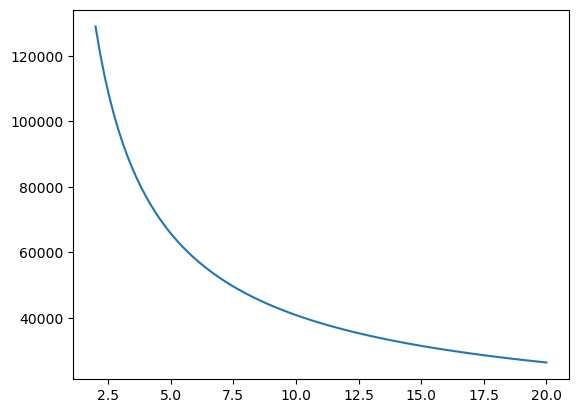

In [ ]:
plt.plot(rankine_cycle_turbine['Pressure Ratio'], rankine_cycle_turbine['Work']*mr_list)

In [ ]:
rankine_cycle_boiler

,Pressure Ratio,Component,Work,Heat,Enthalpy Change,Exergy Change,Irreversibility
0,2.000000,Boiler,0,1.516154e+08,1.516154e+08,1.077063e+08,-1.487743e+07
1,2.181818,Boiler,0,1.385242e+08,1.385242e+08,9.780239e+07,-1.363913e+07
2,2.363636,Boiler,0,1.275033e+08,1.275033e+08,8.950377e+07,-1.258970e+07
3,2.545455,Boiler,0,1.181010e+08,1.181010e+08,8.245485e+07,-1.168901e+07
4,2.727273,Boiler,0,1.099874e+08,1.099874e+08,7.639712e+07,-1.090758e+07
...,...,...,...,...,...,...,...
95,19.272727,Boiler,0,1.607650e+07,1.607650e+07,9.302410e+06,-1.500470e+06
96,19.454545,Boiler,0,1.593879e+07,1.593879e+07,9.212795e+06,-1.486174e+06
97,19.636364,Boiler,0,1.580366e+07,1.580366e+07,9.124918e+06,-1.472145e+06
98,19.818182,Boiler,0,1.567102e+07,1.567102e+07,9.038729e+06,-1.458376e+06


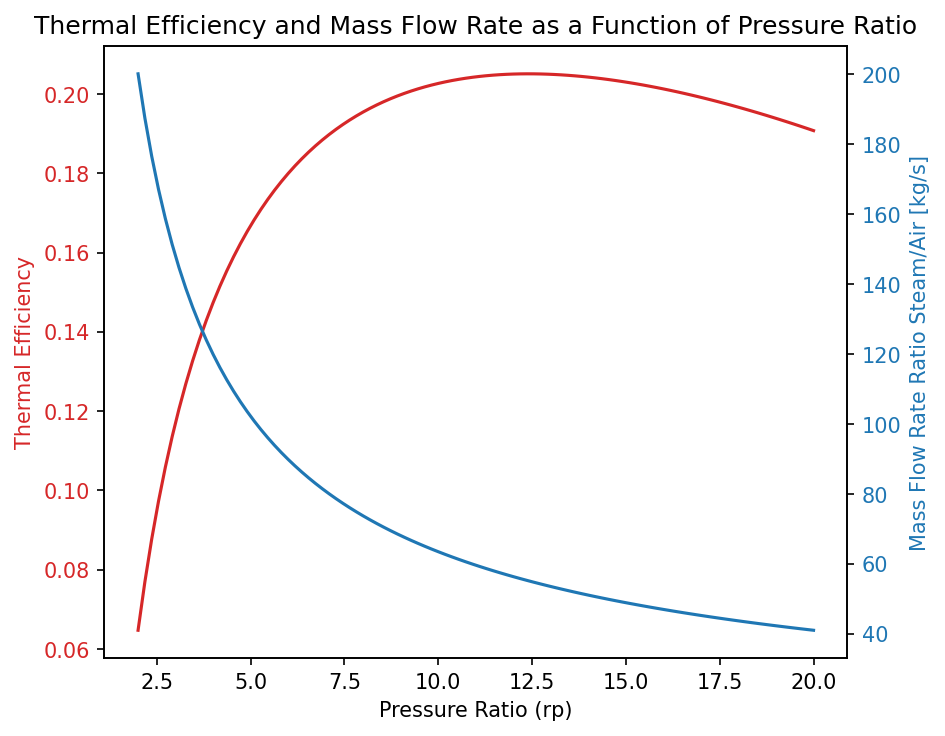

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Pressure Ratio (rp)')
ax1.set_ylabel('Thermal Efficiency', color=color)
ax1.plot(efficiency["Pressure Ratio"], efficiency["Thermal Efficinency"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Mass Flow Rate Ratio Steam/Air [kg/s]', color=color)
ax2.plot(efficiency["Pressure Ratio"], efficiency["Mass Ratio"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.figsize = (8,4)
fig.dpi = 150
fig.tight_layout()
plt.title('Thermal Efficiency and Mass Flow Rate as a Function of Pressure Ratio')
plt.show()

Text(0, 0.5, 'Net Power [W]')

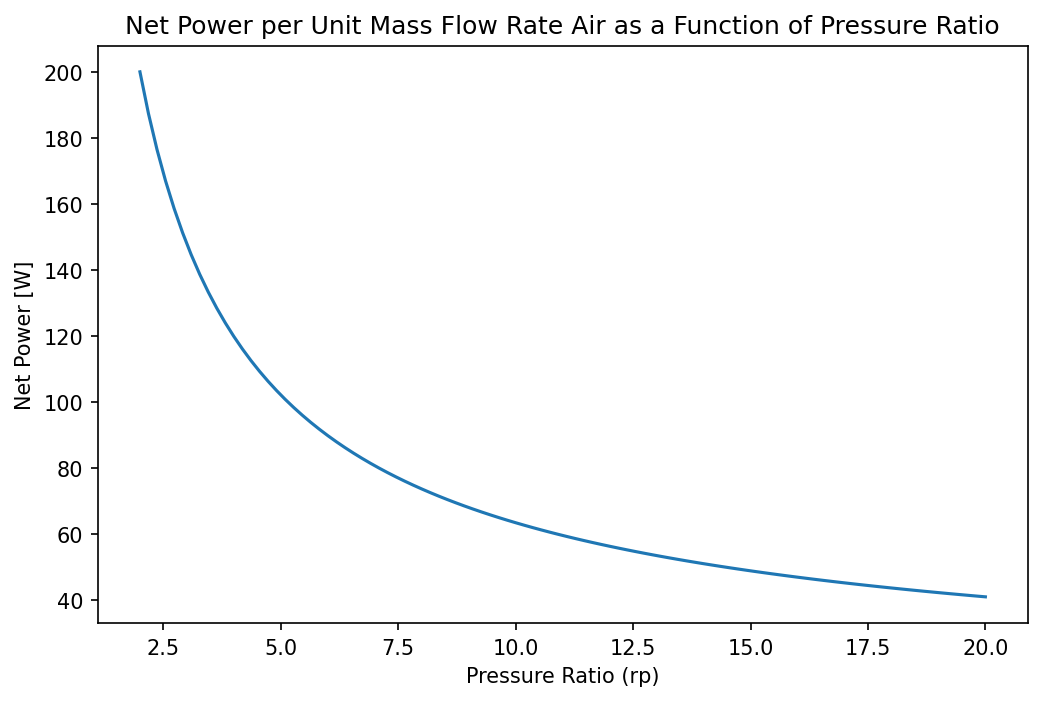

In [ ]:
plt.figure(figsize = ([8,5]), dpi = 150)


plt.plot(efficiency['Pressure Ratio'], efficiency['Mass Ratio'])
plt.title('Net Power per Unit Mass Flow Rate Air as a Function of Pressure Ratio')
plt.xlabel('Pressure Ratio (rp)')
plt.ylabel('Net Power [W]')

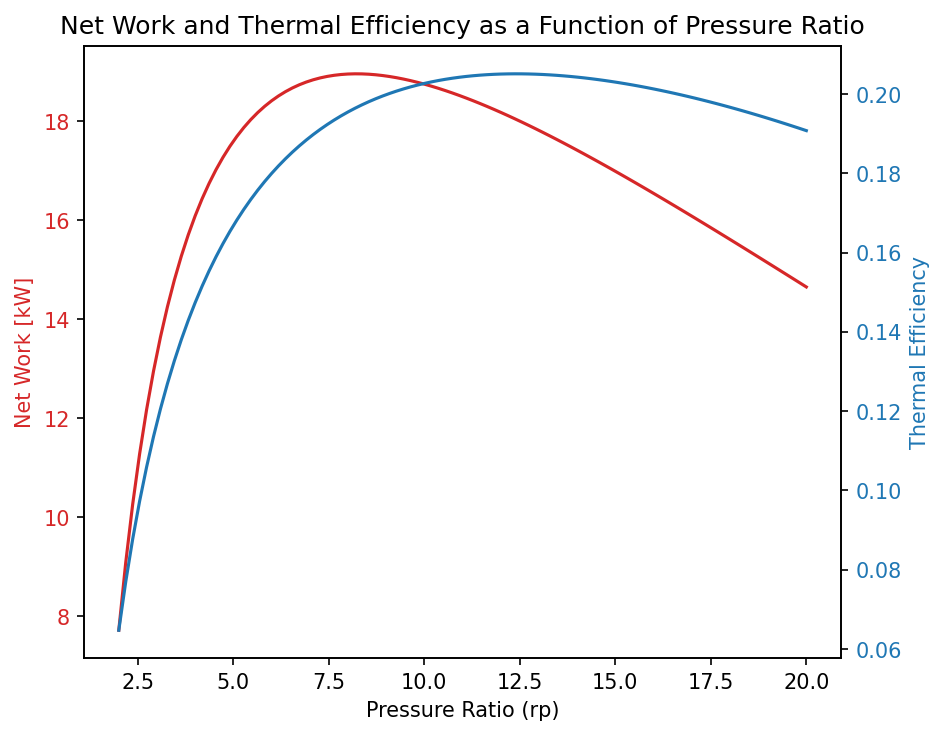

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Pressure Ratio (rp)')
ax1.set_ylabel('Net Work [kW]', color=color)
ax1.plot(efficiency["Pressure Ratio"], efficiency["Net Work"]/10e3, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Thermal Efficiency', color=color)
ax2.plot(efficiency["Pressure Ratio"], efficiency["Thermal Efficinency"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.figsize = (8,4)
fig.dpi = 150
fig.tight_layout()
plt.title('Net Work and Thermal Efficiency as a Function of Pressure Ratio')
plt.show()

In [ ]:
optimum_ratio = efficiency["Pressure Ratio"][np.argmax(efficiency["Thermal Efficinency"])]
print(optimum_ratio)

12.363636363636363


In [ ]:
brayton_cycle_opt = brayton_cycle_compressor[brayton_cycle_compressor["Pressure Ratio"] == optimum_ratio]
print(brayton_cycle_opt)

    Pressure Ratio   Component           Work  Heat  Enthalpy Change  \
57       12.363636  Compressor  394460.755503     0    394460.755503   

    Exergy Change  Irreversibility  Second Law Efficiency  
57  357748.220288     36712.535216                0.90693  


In [ ]:
rankine_cycle_opt = rankine_cycle_pump[rankine_cycle_pump["Pressure Ratio"] == optimum_ratio]
print(rankine_cycle_opt)

    Pressure Ratio Component        Work  Heat  Enthalpy Change  \
57       12.363636      Pump  842.118018     0       842.118018   

    Exergy Change  Irreversibility  Second Law Efficiency  
57     759.580354        82.537664               0.901988  


In [ ]:
second_law_efficiency = brayton_cycle_compressor[["Pressure Ratio", "Second Law Efficiency"]],brayton_cycle_turbine[["Pressure Ratio", "Second Law Efficiency"]], rankine_cycle_pump[["Pressure Ratio", "Second Law Efficiency"]], rankine_cycle_turbine[["Pressure Ratio", "Second Law Efficiency"]]
print(second_law_efficiency[0])

    Pressure Ratio  Second Law Efficiency
0         2.000000               0.839425
1         2.181818               0.843715
2         2.363636               0.847547
3         2.545455               0.850999
4         2.727273               0.854132
..             ...                    ...
95       19.272727               0.917918
96       19.454545               0.918133
97       19.636364               0.918345
98       19.818182               0.918555
99       20.000000               0.918762

[100 rows x 2 columns]


In [ ]:
print(second_law_efficiency[1])

    Pressure Ratio  Second Law Efficiency
0         2.000000               1.086592
1         2.181818               1.088317
2         2.363636               1.089937
3         2.545455               1.091464
4         2.727273               1.092912
..             ...                    ...
95       19.272727               1.146096
96       19.454545               1.146420
97       19.636364               1.146741
98       19.818182               1.147060
99       20.000000               1.147376

[100 rows x 2 columns]


In [ ]:
print(second_law_efficiency[2])

    Pressure Ratio  Second Law Efficiency
0         2.000000               0.901988
1         2.181818               0.901988
2         2.363636               0.901988
3         2.545455               0.901988
4         2.727273               0.901988
..             ...                    ...
95       19.272727               0.901988
96       19.454545               0.901988
97       19.636364               0.901988
98       19.818182               0.901988
99       20.000000               0.901988

[100 rows x 2 columns]


In [ ]:
print(second_law_efficiency[3])

    Pressure Ratio  Second Law Efficiency
0         2.000000               1.044548
1         2.181818               1.045253
2         2.363636               1.045909
3         2.545455               1.046523
4         2.727273               1.047101
..             ...                    ...
95       19.272727               1.065628
96       19.454545               1.065726
97       19.636364               1.065823
98       19.818182               1.065920
99       20.000000               1.066016

[100 rows x 2 columns]


In [ ]:
rankine_cycle_turbine['Work']*mr_list

0     128958.473488
1     120796.984107
2     113774.433631
3     107661.129962
4     102286.033169
          ...      
95     27033.898110
96     26882.254823
97     26733.107204
98     26586.391533
99     26442.046286
Name: Work, Length: 100, dtype: float64